# Computing *k* at the block and sub-block level serially and in parallel

10-01-2021 | nmarchio@uchicago.edu | Mansueto Institute

#### Conda environment setup
```
conda create --name pygeos_env python=3.9.5
source activate pygeos_env
conda config --env --add channels conda-forge
conda config --env --set channel_priority strict
conda install pygeos --channel conda-forge
conda install geopandas
conda install gdal --channel conda-forge
conda install -c conda-forge pyarrow
conda install libpysal
conda install dask
conda install time 
```
#### Additional installs for notebooks
```
conda install ipykernel
conda install -c conda-forge notebook
conda install -c conda-forge nb_conda_kernels
conda install jupyter
python -m ipykernel install --user --name=pygeos_env
```

In [1]:
import time
import warnings
warnings.filterwarnings('ignore', message='.*distributed.diskutils - INFO - *')
from dask.distributed import Client
client = Client(n_workers=2) 
import dask.bag as db
import dask

In [2]:
import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import pyarrow
import re
import os
gpd.options.use_pygeos = True

In [3]:
def build_blocks(gadm_data, osm_data, gadm_level, gadm_code):
    """
    Returns a GeoDataFrame containing all blocks in a GADM
    Args:
        gadm_data: GeoDataFrame, containing GADM delineations (downloaded from https://gadm.org/data.html)
        osm_data: PyGEOS geometry array, of linestrings that delineate blocks within GADMs (i.e., OSM linestrings from from http://download.geofabrik.de/)
        gadm_level: string, integer representing most detailed GID_* column in gadm_data
        gadm_code: string, unique identification code for each GADM GID_* column in gadm_data
    Returns:
        GeoDataFrame with enclosed block delineation geometries for a given 'gadm_code', each block is assigned a unique 'block_id'.
    """
    gadm_data = pygeos.from_shapely(gadm_data[gadm_data['GID_'+ gadm_level] == gadm_code]['geometry'])
    osm_data = pygeos.intersection(pygeos.multilinestrings(osm_data),gadm_data)
    gadm_outline = pygeos.get_exterior_ring(pygeos.get_parts(gadm_data)[pygeos.area(pygeos.get_parts(gadm_data)) == max(pygeos.area(pygeos.get_parts(gadm_data)))])
    gadm_lines = pygeos.line_merge(pygeos.multilinestrings(pygeos.get_exterior_ring(pygeos.get_parts(gadm_data))))
    gadm_lines = pygeos.union(osm_data[0],gadm_lines)
    gadm_blocks = pygeos.union(osm_data[0],gadm_outline)
    gadm_blocks = pygeos.polygonize_full([gadm_blocks])
    gadm_blocks = gpd.GeoDataFrame.from_dict({"country_code": gadm_code[0:3],
                                              "gadm_code": gadm_code,
                                              'geometry': pygeos.to_shapely(pygeos.get_parts(pygeos.normalize(gadm_blocks[0])))}, crs=4326)
    gadm_blocks = gadm_blocks.reset_index(drop=True)
    gadm_blocks = gadm_blocks.assign(block_id = [gadm_code + '_' + str(x) for x in list(gadm_blocks.index)])
    gadm_blocks = gadm_blocks[['block_id','gadm_code','country_code','geometry']].to_crs(epsg=3395)
    return gadm_blocks


In [4]:
def trim_coastline(gadm_data, osm_data):
    """
    Returns a GeoDataFrame containing all blocks in a GADM
    Args:
        gadm_data: GeoDataFrame, containing GADM delineations (downloaded from https://gadm.org/data.html)
        osm_data: GeoDataFrame, containing linestrings coastline features (i.e., OSM linestrings from from http://download.geofabrik.de/)
    Returns:
        GeoDataFrame with polygon(s) of the input geometry with trimmed coastline
    """
    bbox = pygeos.envelope(pygeos.union_all(pygeos.from_shapely(gadm_data['geometry'])))
    bbox_center = pygeos.get_coordinates(pygeos.centroid(bbox)).tolist()
    bbox_enlarge = pygeos.apply(bbox, lambda x: ((x - bbox_center)*1.1 + bbox_center) )
    area = pygeos.from_shapely(gadm_data['geometry'])
    area_center = pygeos.buffer(pygeos.centroid(area), radius=.00001, quadsegs=50) 
    coast = pygeos.union_all(pygeos.from_shapely(osm_data[osm_data['natural'].isin(['coastline','water'])]['geometry']))
    coast_buffer = pygeos.buffer(coast, radius=.00001, quadsegs=50) 
    bbox_poly = pygeos.difference(bbox_enlarge,coast_buffer)
    bbox_poly_parts = pygeos.get_parts(bbox_poly)
    positive_space = bbox_poly_parts[pygeos.intersects(pygeos.multipolygons(area_center), bbox_poly_parts)]
    area_intersect = pygeos.get_parts(pygeos.intersection(pygeos.union_all(area), positive_space))
    area_intersect = area_intersect[pygeos.intersects(pygeos.multipolygons(area_center), area_intersect)]
     
    data = gpd.GeoDataFrame({"geometry": gpd.GeoSeries(pygeos.to_shapely(area_intersect))}).set_crs(epsg=4326)
    return data


In [5]:
def index_buildings(gadm_block_data, bldg_data):
    """
    Returns a GeoDataFrame containing 
    Args:
        gadm_block_data: GeoDataFrame, output returned from build_blocks() function
        bldg_data: GeoDataFrame, containing building geometries
    Returns:
        GeoDataFrame with building geometries mapped to 'block_id','gadm_code','country_code'.
    """
    gadm_block_data = gadm_block_data.to_crs(epsg=3395)
    bldg_data = bldg_data.to_crs(epsg=3395)
    bldg_points = bldg_data.copy()
    bldg_points['geometry'] = bldg_points.centroid
    bldg_index = bldg_points.sindex
    index_bulk = bldg_index.query_bulk(gadm_block_data['geometry'], predicate="intersects")
    blocks_buildings_map = pd.DataFrame({'index_blocks': index_bulk[0], 'index_buildings': index_bulk[1]})
    blocks_buildings_map = blocks_buildings_map.merge(bldg_data[['geometry']], how = 'left', left_on='index_buildings', right_index=True)
    blocks_buildings_map = blocks_buildings_map.merge(gadm_block_data[['block_id','gadm_code','country_code']], left_on='index_blocks', right_index=True)
    bldg_data = gpd.GeoDataFrame(blocks_buildings_map[['block_id','gadm_code','country_code','geometry']]).to_crs(epsg=3395)
    return bldg_data


In [6]:
def compute_k(block_data, bldg_data, block_col, block_id, street_linestrings=None, buffer_streets=False):
    """
    Returns a GeoDataFrame containing k-complexity value for each block
    Args:
        block_data: GeoDataFrame, output returned from build_blocks() function
        bldg_data: GeoDataFrame, output returned from index_buildings() function
        block_col: string, column that contains the block_id codes (present in block_data and bldg_data)
        block_id: string, unique identification code of block_id string in block_col
        street_linestrings: PyGEOS geometry array, linestrings representing street accesses (optional)
        buffer_streets: bool, default False, if True removes all disconnected streets in a buffer radius of 30
    Returns:
        GeoDataFrame with block geometries and the columns: 
            'block_id','block_area','building_area','building_count','building_layers','k_complexity'
    """
    block_layers = [] 

    bldg_data = bldg_data[bldg_data[block_col] == block_id].to_crs(epsg=3395)
    block_data = block_data[block_data[block_col] == block_id].to_crs(epsg=3395) 
    
    country_code = block_data['country_code'].unique()[0] 
    gadm_code = block_data['gadm_code'].unique()[0] 
    
    block_area = round(pygeos.area(pygeos.multipolygons(pygeos.from_shapely(block_data['geometry']))),2)
    bldg_array = pygeos.from_shapely(bldg_data['geometry'])
    bldg_area_list = pygeos.area(bldg_array)
    bldg_area = round(sum(bldg_area_list),2)
    bldg_count = np.sum(pygeos.get_num_geometries(bldg_array))
        
    if bldg_count not in [1,0]:
            
        bldg_data["geometry"] = bldg_data.centroid
        building_points = pygeos.multipoints(pygeos.from_shapely(bldg_data["geometry"]))
        points = pygeos.get_parts(building_points)
        block = pygeos.from_shapely(block_data['geometry'])
        voronoi = pygeos.get_parts(pygeos.voronoi_polygons(geometry=building_points, extend_to=block))
        if not pygeos.is_valid(block): block = pygeos.make_valid(block)
        block_parcels = pygeos.intersection(block, voronoi)    
        bldg_count = np.sum(pygeos.get_num_geometries(block_parcels))

        if street_linestrings is not None:
            street_linestrings = pygeos.intersection(pygeos.multilinestrings(street_linestrings),block)
            if buffer_streets == True:
                connected_streets = pygeos.get_parts(pygeos.buffer(street_linestrings, radius=30, quadsegs=5)) 
                connected_streets = connected_streets[pygeos.length(connected_streets).argsort()[::-1] == 0]
                exterior_boundary = pygeos.buffer(pygeos.get_exterior_ring(block), radius=60, quadsegs=5)
                complete_buffer = pygeos.union(connected_streets, exterior_boundary)
                street_linestrings = pygeos.intersection(street_linestrings,complete_buffer)
            if pygeos.is_empty(street_linestrings[0]) == False:
                block_intersect = pygeos.intersects(street_linestrings,block_parcels)
                block_parcels_outer = block_parcels[block_intersect]
                block_layers.append( str(np.sum(pygeos.get_num_geometries(block_parcels_outer))))
                block_depth = len(block_layers)
                block_parcels = block_parcels[~block_intersect]
                if len(block_parcels_outer) == 0: 
                    block_parcels_outer = block_parcels.copy()
            else: block_parcels_outer = block_parcels.copy()

        parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels))

        while parcel_residual > 0:

            block_reduced = pygeos.coverage_union_all(block_parcels_outer)
            block_parcels_inner = block_parcels[~pygeos.touches(block_parcels,block_reduced)]      
            block_parcels_outer = block_parcels[pygeos.touches(block_parcels,block_reduced)]  
            if np.sum(pygeos.get_num_geometries(block_parcels_outer)) == 0 and np.sum(pygeos.get_num_geometries(block_parcels_inner)) > 0:
                block_reduced = pygeos.coverage_union_all(block_parcels_inner)
                center = pygeos.get_coordinates(pygeos.centroid(block_reduced)).tolist()
                block_interior = pygeos.apply(block_reduced, lambda x: ((x - center)*.9999 + center) )
                block_exterior = pygeos.difference(block_reduced, block_interior)
                block_ring = pygeos.intersects(block_exterior, block_parcels_inner)
                block_parcels_outer = block_parcels_inner[block_ring]
                block_parcels_inner = block_parcels_inner[~block_ring]
            block_parcels = block_parcels_inner.copy()
            parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels_inner))
            if parcel_residual == 0: 
                block_layers.append( str(np.sum(pygeos.get_num_geometries(block_parcels_outer))))
                block_depth = len(block_layers)
                break
            block_layers.append( str(np.sum(pygeos.get_num_geometries(block_parcels_outer))))
            block_depth = len(block_layers) 
        else:
            block_depth = len(block_layers)
            
    else:
        block_layers.append( str(bldg_count))
        block_depth = len(block_layers)
        
    data = gpd.GeoDataFrame.from_dict({'block_id': [block_id], 
                                       'gadm_code': gadm_code,
                                       'country_code': country_code,
                                       'block_area': float(block_area),
                                       'building_area': float(bldg_area),
                                       'building_count': int(bldg_count),
                                       'building_layers': ','.join(block_layers), 
                                       'k_complexity': int(block_depth), 
                                       'geometry': block_data['geometry']}).to_crs(epsg=4326)
    return data



In [7]:
def compute_layers(block_data, bldg_data, block_col, block_id, street_linestrings=None, buffer_streets=False):
    """
    Returns a GeoDataFrame containing k-complexity layers in each row for a block
    Args:
        block_data: GeoDataFrame, output returned from build_blocks() function
        bldg_data: GeoDataFrame, output returned from index_buildings() function
        block_col: string, column that contains the block_id codes (present in block_data and bldg_data)
        block_id: string, unique identification code of block_id string in block_col
        street_linestrings: PyGEOS geometry array, linestrings representing street accesses (optional)
        buffer_streets: bool, default False, if True removes all disconnected streets in a buffer radius of 30
    Returns:
        GeoDataFrame with block-layer geometries and the columns: 
            'block_id','gadm_code','country_code','building_count','k_complexity'
    """
    block_layers = [] 
    block_layers_geometry = []
    k_complexity = []
    bldg_data = bldg_data[bldg_data[block_col] == block_id].to_crs(epsg=3395)
    block_data = block_data[block_data[block_col] == block_id].to_crs(epsg=3395) 
    country_code = block_data['country_code'].unique()[0] 
    gadm_code = block_data['gadm_code'].unique()[0] 
    bldg_array = pygeos.from_shapely(bldg_data['geometry'])
    bldg_count = np.sum(pygeos.get_num_geometries(bldg_array))
    
    if bldg_count not in [1,0]:
        bldg_data["geometry"] = bldg_data.centroid
        building_points = pygeos.multipoints(pygeos.from_shapely(bldg_data["geometry"]))
        points = pygeos.get_parts(building_points)
        block = pygeos.from_shapely(block_data['geometry'])
        voronoi = pygeos.get_parts(pygeos.voronoi_polygons(geometry=building_points, extend_to=block))
        if not pygeos.is_valid(block): block = pygeos.make_valid(block)
        block_parcels = pygeos.intersection(block, voronoi)    
        bldg_count = np.sum(pygeos.get_num_geometries(block_parcels))
        
        if street_linestrings is not None:
            street_linestrings = pygeos.intersection(pygeos.multilinestrings(street_linestrings),block)
            if buffer_streets == True:
                connected_streets = pygeos.get_parts(pygeos.buffer(street_linestrings, radius=30, quadsegs=5)) 
                connected_streets = connected_streets[pygeos.length(connected_streets).argsort()[::-1] == 0]
                exterior_boundary = pygeos.buffer(pygeos.get_exterior_ring(block), radius=60, quadsegs=5)
                complete_buffer = pygeos.union(connected_streets, exterior_boundary)
                street_linestrings = pygeos.intersection(street_linestrings,complete_buffer)
            if pygeos.is_empty(street_linestrings[0]) == False:
                block_intersect = pygeos.intersects(street_linestrings,block_parcels)
                block_parcels_outer = block_parcels[block_intersect]
                block_layers.append(np.sum(pygeos.get_num_geometries(block_parcels_outer)))
                block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
                block_depth = len(block_layers)
                k_complexity.append(block_depth)
                block_parcels = block_parcels[~block_intersect]
                if len(block_parcels_outer) == 0: 
                    block_parcels_outer = block_parcels.copy()
            else: block_parcels_outer = block_parcels.copy()
 
        parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels))
        
        while parcel_residual > 0:
            block_reduced = pygeos.coverage_union_all(block_parcels_outer)
            block_parcels_inner = block_parcels[~pygeos.touches(block_parcels,block_reduced)]      
            block_parcels_outer = block_parcels[pygeos.touches(block_parcels,block_reduced)] 
            if np.sum(pygeos.get_num_geometries(block_parcels_outer)) == 0 and np.sum(pygeos.get_num_geometries(block_parcels_inner)) > 0:
                block_reduced = pygeos.coverage_union_all(block_parcels_inner)
                center = pygeos.get_coordinates(pygeos.centroid(block_reduced)).tolist()
                block_interior = pygeos.apply(block_reduced, lambda x: ((x - center)*.9999 + center) )
                block_exterior = pygeos.difference(block_reduced, block_interior)
                block_ring = pygeos.intersects(block_exterior, block_parcels_inner)
                block_parcels_outer = block_parcels_inner[block_ring]
                block_parcels_inner = block_parcels_inner[~block_ring]
            block_parcels = block_parcels_inner.copy()
            parcel_residual = np.sum(pygeos.get_num_geometries(block_parcels_inner))
            
            if parcel_residual == 0: 
                block_layers.append(np.sum(pygeos.get_num_geometries(block_parcels_outer)))
                block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
                block_depth = len(block_layers)
                k_complexity.append(block_depth)
                break
                
            block_layers.append(np.sum(pygeos.get_num_geometries(block_parcels_outer)))
            block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
            block_depth = len(block_layers) 
            k_complexity.append(block_depth)
        else:
            block_depth = len(block_layers)
            k_complexity.append(block_depth)
    else:
        block_layers.append(bldg_count)
        block_layers_geometry.append(pygeos.geometrycollections(block_parcels_outer))
        block_depth = len(block_layers)
        k_complexity.append(block_depth)

    data = gpd.GeoDataFrame.from_dict({'block_id': block_id, 
                                       'gadm_code': gadm_code,
                                       'country_code': country_code,
                                       'building_count': block_layers,
                                       'k_complexity': k_complexity,
                                       'geometry': pygeos.to_shapely(block_layers_geometry)}).set_crs(epsg=3395)
    return data


## Data Inputs
[Box link to example data for Sierra Leone](https://uchicago.box.com/s/kz0lqn906itqw6nn16oyk2xncrx1r84m)

In [8]:
%pwd
#%cd

'/Users/nm/Desktop/Projects/work/mnp/mnp-dev'

#### Read in country-level GADM delineations

In [9]:
# Read in the GADM of country
gadm_gpd = gpd.read_file('./data/gadm/gadm36_SLE_3.shp').to_crs(epsg = 4326)
# Construct list of GADMs
gadm_level = max([(re.sub('GID_', '', i)) for i in list(filter(re.compile("GID_*").match, list(gadm_gpd.columns)))])
gadm_list = list(gadm_gpd['GID_'+ gadm_level].unique())


#### Read in  country-level OSM 'highway' linestrings


In [10]:
# Read in the OSM linestring blob
osm_gpd = gpd.read_file('./data/osm/sierra-leone_lines.geojson').to_crs(epsg = 4326)
# PyGEOS array for generating blocks
osm_pygeos = pygeos.from_shapely(osm_gpd['geometry'])
# PyGEOS array for internal street networks
osm_highways = pygeos.from_shapely(osm_gpd[osm_gpd['highway'].notnull()]['geometry'].to_crs(epsg=3395))


#### Trim the country-level GADM to fit within coastlines

In [11]:
gadm_gpd_trim = trim_coastline(gadm_data = gadm_gpd, osm_data = osm_gpd)
gadm_gpd = gpd.clip(gdf = gadm_gpd, mask = gadm_gpd_trim, keep_geom_type=True)


#### Read in GADM-level buildings polygons

In [12]:
# Set building file directory path
building_path = '/Users/nm/Downloads/'
country_code = 'SLE'
# Construct list of building files in directory
building_files = list(filter(re.compile("buildings_").match, sorted(list(os.listdir(str(building_path + country_code))))))  


## Computation Examples

#### Generate blocks and join to building geometries

In [13]:
%%time
gadm_id = 'SLE.4.2.1_1'
gadm_blocks = build_blocks(gadm_data = gadm_gpd, 
                           osm_data = osm_pygeos, 
                           gadm_level = gadm_level,
                           gadm_code = gadm_id)
gadm_blocks_list = list(gadm_blocks['block_id'].unique())
building_file = list(filter(re.compile(str("%s" % gadm_id +'.geojson')).findall, sorted(building_files)))[0]
building_gpd = gpd.read_file(str(building_path + country_code + '/' + building_file)).to_crs(epsg=3395)
block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, bldg_data = building_gpd)

 

CPU times: user 16.1 s, sys: 1e+03 ms, total: 17.1 s
Wall time: 17 s


<AxesSubplot:>

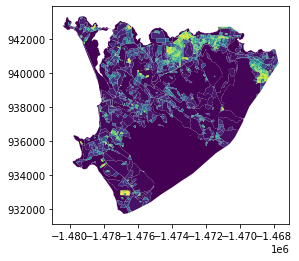

In [14]:
gadm_blocks['geometry'].plot(cmap = 'viridis')

#### Run *k*-function on a single block (returns 1 block-level record in each row with *k*-value)

In [15]:
%%time
k_block = compute_k(block_data = gadm_blocks,
                    bldg_data = block_coded_buildings, 
                    block_col = 'block_id', 
                    block_id = 'SLE.4.2.1_1_70',
                    street_linestrings = osm_highways,
                    buffer_streets=True) 

CPU times: user 492 ms, sys: 12 ms, total: 504 ms
Wall time: 400 ms


In [16]:
k_block.head()

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
70,SLE.4.2.1_1_70,SLE.4.2.1_1,SLE,106940.9,18448.58,216,"85,80,34,16,1",5,"POLYGON ((-13.25079 8.45523, -13.25079 8.45533..."


In [17]:
k_block.dtypes

block_id             object
gadm_code            object
country_code         object
block_area          float64
building_area       float64
building_count        int64
building_layers      object
k_complexity          int64
geometry           geometry
dtype: object

<AxesSubplot:>

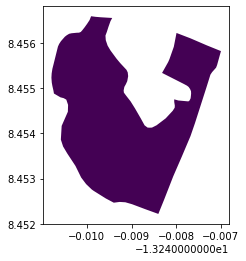

In [18]:
k_block.plot(column='k_complexity', cmap = 'viridis')


#### Calculate *k*-complexity layers which is useful for inspecting blocks (returns several records for each building layer within a block)

In [19]:
%%time
k_layers = compute_layers(block_data = gadm_blocks, 
                          bldg_data = block_coded_buildings, 
                          block_col = 'block_id', 
                          block_id = 'SLE.4.2.1_1_14',
                          street_linestrings=osm_highways,
                          buffer_streets = True) 


CPU times: user 2min 59s, sys: 2.28 s, total: 3min 2s
Wall time: 3min


In [20]:
k_layers.head(5)

,block_id,gadm_code,country_code,building_count,k_complexity,geometry
0,SLE.4.2.1_1_14,SLE.4.2.1_1,SLE,1225,1,GEOMETRYCOLLECTION (POLYGON ((-1474140.642 939...
1,SLE.4.2.1_1_14,SLE.4.2.1_1,SLE,1743,2,GEOMETRYCOLLECTION (POLYGON ((-1474114.043 939...
2,SLE.4.2.1_1_14,SLE.4.2.1_1,SLE,1371,3,GEOMETRYCOLLECTION (POLYGON ((-1473896.010 940...
3,SLE.4.2.1_1_14,SLE.4.2.1_1,SLE,1062,4,GEOMETRYCOLLECTION (POLYGON ((-1474033.158 939...
4,SLE.4.2.1_1_14,SLE.4.2.1_1,SLE,838,5,GEOMETRYCOLLECTION (POLYGON ((-1473971.535 939...


<AxesSubplot:>

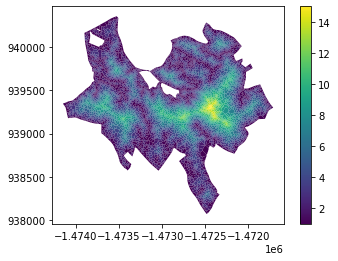

In [21]:
k_layers.plot(column='k_complexity', legend=True, cmap = 'viridis')


#### Test *k*-function on a series of blocks

In [22]:
test_sequence = ['SLE.4.2.1_1_47', 'SLE.4.2.1_1_62', 'SLE.4.2.1_1_117', 'SLE.4.2.1_1_207', 'SLE.4.2.1_1_294', 
                 'SLE.4.2.1_1_244', 'SLE.4.2.1_1_347', 'SLE.4.2.1_1_348', 'SLE.4.2.1_1_550', 'SLE.4.2.1_1_1045']


#### Run *k*-function serially across blocks

In [23]:
%%time
sequence_list = test_sequence
results_serial = gpd.GeoDataFrame({'block_id': pd.Series(dtype='str'), 'gadm_code': pd.Series(dtype='str'), 'country_code': pd.Series(dtype='str'),
                                    'block_area': pd.Series(dtype='float'), 'building_area': pd.Series(dtype='float'), 
                                    'building_count': pd.Series(dtype='int'), 'building_layers': pd.Series(dtype='object'),  'k_complexity': pd.Series(dtype='int'), 
                                    'geometry': pd.Series(dtype='geometry')}).set_crs(epsg=4326)

block_metrics = []
for x in sequence_list: 
    df_k = compute_k(block_data = gadm_blocks,
                     bldg_data = block_coded_buildings, 
                     block_col = 'block_id', 
                     block_id = x,
                     street_linestrings = osm_highways,
                     buffer_streets=True)
    block_metrics.append(df_k)
        
results_serial = results_serial.append(block_metrics, ignore_index=True)


CPU times: user 3.14 s, sys: 74.8 ms, total: 3.21 s
Wall time: 3.17 s


In [24]:
results_serial.head(5)

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
0,SLE.4.2.1_1_47,SLE.4.2.1_1,SLE,300415.44,55269.18,557,"200,229,99,29",4,"POLYGON ((-13.25976 8.46077, -13.25962 8.46098..."
1,SLE.4.2.1_1_62,SLE.4.2.1_1,SLE,99286.11,24891.46,305,"101,113,64,23,4",5,"POLYGON ((-13.26070 8.45581, -13.26069 8.45582..."
2,SLE.4.2.1_1_117,SLE.4.2.1_1,SLE,68680.85,11598.34,150,"55,57,33,5",4,"POLYGON ((-13.25831 8.45591, -13.25765 8.45623..."
3,SLE.4.2.1_1_207,SLE.4.2.1_1,SLE,38522.72,2667.05,24,"17,7",2,"POLYGON ((-13.25570 8.46055, -13.25569 8.46063..."
4,SLE.4.2.1_1_294,SLE.4.2.1_1,SLE,22055.77,2491.48,24,"14,10",2,"POLYGON ((-13.25408 8.45868, -13.25405 8.45870..."


<AxesSubplot:>

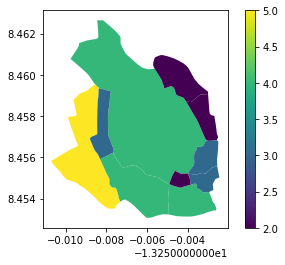

In [25]:
results_serial.plot(column='k_complexity', legend=True, cmap = 'viridis')


#### Run *k*-function across 2-partitions of blocks in parallel

In [26]:
%%time
bag_sequence = db.from_sequence(test_sequence, npartitions=2) # partition_size=2
compute_sequence = bag_sequence.map(lambda x: compute_k(block_data = gadm_blocks,
                                                        bldg_data = block_coded_buildings, 
                                                        block_col = 'block_id', 
                                                        block_id = x,
                                                        street_linestrings = osm_highways,
                                                        buffer_streets=True))

output_sequence = compute_sequence.compute()
#output_sequence = compute_sequence.persist() # use when on a cluster
results_parallel = gpd.GeoDataFrame({'block_id': pd.Series(dtype='str'), 'gadm_code': pd.Series(dtype='str'), 'country_code': pd.Series(dtype='str'),
                                    'block_area': pd.Series(dtype='float'), 'building_area': pd.Series(dtype='float'), 
                                    'building_count': pd.Series(dtype='int'), 'building_layers': pd.Series(dtype='object'),  'k_complexity': pd.Series(dtype='int'), 
                                    'geometry': pd.Series(dtype='geometry')}).set_crs(epsg=4326)

for i,j in enumerate(output_sequence): results_parallel = results_parallel.append(output_sequence[i], 
                                                                                  ignore_index=True)


CPU times: user 4.78 s, sys: 802 ms, total: 5.59 s
Wall time: 9.02 s


In [27]:
results_parallel.head(5)

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
0,SLE.4.2.1_1_47,SLE.4.2.1_1,SLE,300415.44,55269.18,557,"200,229,99,29",4,"POLYGON ((-13.25976 8.46077, -13.25962 8.46098..."
1,SLE.4.2.1_1_62,SLE.4.2.1_1,SLE,99286.11,24891.46,305,"101,113,64,23,4",5,"POLYGON ((-13.26070 8.45581, -13.26069 8.45582..."
2,SLE.4.2.1_1_117,SLE.4.2.1_1,SLE,68680.85,11598.34,150,"55,57,33,5",4,"POLYGON ((-13.25831 8.45591, -13.25765 8.45623..."
3,SLE.4.2.1_1_207,SLE.4.2.1_1,SLE,38522.72,2667.05,24,"17,7",2,"POLYGON ((-13.25570 8.46055, -13.25569 8.46063..."
4,SLE.4.2.1_1_294,SLE.4.2.1_1,SLE,22055.77,2491.48,24,"14,10",2,"POLYGON ((-13.25408 8.45868, -13.25405 8.45870..."


<AxesSubplot:>

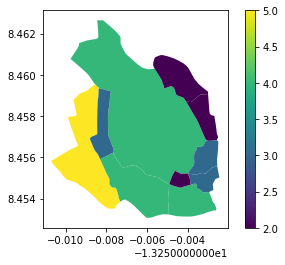

In [28]:
results_parallel.plot(column='k_complexity', legend=True, cmap = 'viridis')

#### Run serialized computation over *n* GADM areas, subdivide into *n* blocks, and serially iterate through hundreds of blocks

In [29]:
%%time

k_output_serial = gpd.GeoDataFrame({'block_id': pd.Series(dtype='str'), 'gadm_code': pd.Series(dtype='str'), 'country_code': pd.Series(dtype='str'),
                                    'block_area': pd.Series(dtype='float'), 'building_area': pd.Series(dtype='float'), 
                                    'building_count': pd.Series(dtype='int'), 'building_layers': pd.Series(dtype='object'),  'k_complexity': pd.Series(dtype='int'), 
                                    'geometry': pd.Series(dtype='geometry')}).set_crs(epsg=4326)

#freelist = ['SLE.4.1.4_1'] 'SLE.4.1.2_1', 'SLE.4.1.1_1', 'SLE.4.1.3_1','SLE.4.2.1_1'
for i in gadm_list[1:2]: 
    print(i)
    gadm_blocks = build_blocks(gadm_data = gadm_gpd, 
                               osm_data = osm_pygeos, 
                               gadm_level = gadm_level,
                               gadm_code = i)

    gadm_blocks_list = list(gadm_blocks['block_id'].unique())
    
    building_file = list(filter(re.compile(str("%s" % i +'.geojson')).findall, sorted(building_files)))[0]
    building_gpd = gpd.read_file(str(building_path + country_code + '/' + building_file)).to_crs(epsg=4326)
    
    block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, 
                                            bldg_data = building_gpd)
    
    block_metrics = []
    
    for x in gadm_blocks_list: 
        #print(x)
        df_k = compute_k(block_data = gadm_blocks,
                         bldg_data = block_coded_buildings, 
                         block_col = 'block_id', 
                         block_id = x,
                         street_linestrings = osm_highways,
                         buffer_streets=True)
        block_metrics.append(df_k)
        
    k_output_serial = k_output_serial.append(block_metrics, ignore_index=True)



SLE.1.1.2_1
CPU times: user 38.5 s, sys: 986 ms, total: 39.5 s
Wall time: 39 s


In [30]:
k_output_serial.head(5)

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
0,SLE.1.1.2_1_0,SLE.1.1.2_1,SLE,32814030.79,29160.87,465,"145,182,104,30,4",5,"POLYGON ((-10.99324 7.83366, -10.99322 7.83454..."
1,SLE.1.1.2_1_1,SLE.1.1.2_1,SLE,82795637.08,39242.52,728,"257,291,146,33,1",5,"POLYGON ((-10.96699 7.77914, -10.96660 7.77911..."
2,SLE.1.1.2_1_2,SLE.1.1.2_1,SLE,10540446.51,15084.58,252,"67,89,67,25,4",5,"POLYGON ((-10.93411 7.83798, -10.93391 7.83814..."
3,SLE.1.1.2_1_3,SLE.1.1.2_1,SLE,20948405.32,25262.90,365,"70,112,104,64,15",5,"POLYGON ((-11.01570 7.88252, -11.01565 7.88273..."
4,SLE.1.1.2_1_4,SLE.1.1.2_1,SLE,9024868.63,6420.80,122,"40,42,34,6",4,"POLYGON ((-10.96316 7.89072, -10.96315 7.89080..."


<AxesSubplot:>

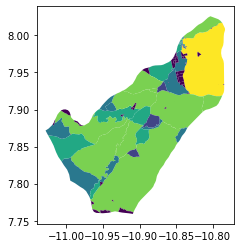

In [31]:
k_output_serial.plot(column='k_complexity', legend=False, cmap = 'viridis')


In [32]:
k_output_serial.dtypes

block_id             object
gadm_code            object
country_code         object
block_area          float64
building_area       float64
building_count        int64
building_layers      object
k_complexity          int64
geometry           geometry
dtype: object

#### Run serialized computation over *n* GADM areas, subdivide into *n* blocks, and parallelize block-level computation

In [33]:
%%time
k_output_parallel = gpd.GeoDataFrame({'block_id': pd.Series(dtype='str'), 'gadm_code': pd.Series(dtype='str'), 'country_code': pd.Series(dtype='str'),
                                    'block_area': pd.Series(dtype='float'), 'building_area': pd.Series(dtype='float'), 
                                    'building_count': pd.Series(dtype='int'), 'building_layers': pd.Series(dtype='object'),  'k_complexity': pd.Series(dtype='int'), 
                                    'geometry': pd.Series(dtype='geometry')}).set_crs(epsg=4326)

for i in gadm_list[1:2]: 
    print(i)
    gadm_blocks = build_blocks(gadm_data = gadm_gpd, 
                               osm_data = osm_pygeos, 
                               gadm_level = gadm_level,
                               gadm_code = i)

    gadm_blocks_list = list(gadm_blocks['block_id'].unique())
    
    building_file = list(filter(re.compile(str("%s" % i +'.geojson')).findall, sorted(building_files)))[0]
    building_gpd = gpd.read_file(str(building_path + country_code + '/' + building_file)).to_crs(epsg=4326)
    
    block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, 
                                            bldg_data = building_gpd)
    
    bag_sequence = db.from_sequence(gadm_blocks_list, npartitions=2) #partition_size=2
    compute_sequence = bag_sequence.map(lambda x: compute_k(block_data = gadm_blocks,
                                                            bldg_data = block_coded_buildings, 
                                                            block_col = 'block_id', 
                                                            block_id = x,
                                                            street_linestrings = osm_highways,
                                                            buffer_streets=True))
        
    output_sequence = compute_sequence.compute()
    #output_sequence = compute_sequence.persist() # use when on a cluster
    for i,j in enumerate(output_sequence): k_output_parallel = k_output_parallel.append(output_sequence[i], 
                                                                                        ignore_index=True)



SLE.1.1.2_1
CPU times: user 4.79 s, sys: 537 ms, total: 5.32 s
Wall time: 40.8 s


In [34]:
k_output_parallel.head(5)

,block_id,gadm_code,country_code,block_area,building_area,building_count,building_layers,k_complexity,geometry
0,SLE.1.1.2_1_0,SLE.1.1.2_1,SLE,32814030.79,29160.87,465,"145,182,104,30,4",5,"POLYGON ((-10.99324 7.83366, -10.99322 7.83454..."
1,SLE.1.1.2_1_1,SLE.1.1.2_1,SLE,82795637.08,39242.52,728,"257,291,146,33,1",5,"POLYGON ((-10.96699 7.77914, -10.96660 7.77911..."
2,SLE.1.1.2_1_2,SLE.1.1.2_1,SLE,10540446.51,15084.58,252,"67,89,67,25,4",5,"POLYGON ((-10.93411 7.83798, -10.93391 7.83814..."
3,SLE.1.1.2_1_3,SLE.1.1.2_1,SLE,20948405.32,25262.90,365,"70,112,104,64,15",5,"POLYGON ((-11.01570 7.88252, -11.01565 7.88273..."
4,SLE.1.1.2_1_4,SLE.1.1.2_1,SLE,9024868.63,6420.80,122,"40,42,34,6",4,"POLYGON ((-10.96316 7.89072, -10.96315 7.89080..."


<AxesSubplot:>

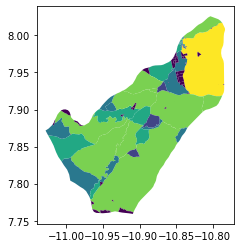

In [35]:
k_output_parallel.plot(column='k_complexity', legend=False, cmap = 'viridis')


## Write Outputs

In [36]:
print(k_output_serial.crs)
print(k_layers.crs)

epsg:4326
epsg:3395


#### Write block-level output for an entire GADM to GeoJSON and Parquet file

In [37]:
k_output_serial.to_file('/Users/nm/Desktop/kblock_test.geojson', driver='GeoJSON') 
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
k_output_serial.to_parquet('/Users/nm/Desktop/kblock_test.parquet')  


#### Write *k*-layer output with buildings and streets for an individual block to GeoJSON file

In [38]:
# Complexity layers in block 'SLE.4.2.1_1_14'
k_layers.to_file('/Users/nm/Desktop/k_layer.geojson', driver='GeoJSON')

# Buildings in block 'SLE.4.2.1_1_14'
gadm_blocks = build_blocks(gadm_data = gadm_gpd, osm_data = osm_pygeos, gadm_level = '3', gadm_code = 'SLE.4.2.1_1')
building_gpd = gpd.read_file(str(building_path + 'SLE/buildings_SLE.4.2.1_1.geojson')).to_crs(epsg=4326)
block_coded_buildings = index_buildings(gadm_block_data = gadm_blocks, bldg_data = building_gpd)
k_layers_buildings = block_coded_buildings[block_coded_buildings['block_id'] == 'SLE.4.2.1_1_14'].to_crs(epsg=3395)
k_layers_buildings.to_file('/Users/nm/Desktop/k_layer_bldgs.geojson', driver='GeoJSON') 

# Streets in block 'SLE.4.2.1_1_14'
k_layers_streets = pygeos.intersection(pygeos.multilinestrings(osm_highways), pygeos.coverage_union_all(pygeos.from_shapely(k_layers['geometry'])))
connected_streets = pygeos.get_parts(pygeos.buffer(k_layers_streets, radius=30, quadsegs=5)) 
connected_streets = connected_streets[pygeos.length(connected_streets).argsort()[::-1] == 0]
k_layers_streets = pygeos.intersection(k_layers_streets,connected_streets)
k_layers_streets = gpd.GeoDataFrame({'streets':1,"geometry": gpd.GeoSeries(pygeos.to_shapely(k_layers_streets))}).set_crs(epsg=3395)  
k_layers_streets.to_file('/Users/nm/Desktop/k_layer_streets.geojson', driver='GeoJSON')  
